In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KDTree
from tqdm.autonotebook import tqdm

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def read_laserdata(filename="laserdata.txt"):
    df = pd.read_csv(filename, sep=' ', header=None)
    laser_data = df.to_numpy()
    return laser_data


def read_image(filename="test_image_gray.tif"):
    image = plt.imread(filename)
    return image

In [8]:
def read_camera_orientation_info(filename="camera_orientation_info.txt"):

    with open(filename, 'r') as f:
        lines = f.read().splitlines()

    pp_x = float(lines[1])
    pp_y = float(lines[2])
    c = float(lines[4])

    x_0 = float(lines[9])
    y_0 = float(lines[10])
    z_0 = float(lines[11])

    r = np.zeros((3, 3))

    for i in range(3):
        str_row = lines[13 + i].split("\t")
        r[i] = [float(x) for x in str_row]

    return pp_x, pp_y, c, r, x_0, y_0, z_0

In [9]:
laser = read_laserdata()
laser_x = laser[:, 0]
laser_y = laser[:, 1]
laser_z = laser[:, 2]

In [10]:
pp_x, pp_y, c, r, x0, y0, z0 = read_camera_orientation_info()

In [11]:
orthophoto = read_image()
n_pixel_rows, n_pixel_columns = orthophoto.shape

In [12]:
def collinearity_equations(X, Y, Z, c, x0, y0, z0, r):
    
    n = len(X)
    
    x_cam = np.zeros(n)
    y_cam = np.zeros(n)
    
    for i, x, y, z in zip(range(n), X, Y, Z):
        
        denom = r[2, 0]*(x-x0) + r[2, 1]*(y-y0) + r[2, 2]*(z-z0)
    
        x_i = -c * (r[0, 0]*(x-x0) + r[0, 1]*(y-y0) + r[0, 2]*(z-z0)) / denom

        y_i = -c * (r[1, 0]*(x-x0) + r[1, 1]*(y-y0) + r[1, 2]*(z-z0)) / denom
        
        x_cam[i] = x_i
        y_cam[i] = y_i
        
    return x_cam, y_cam

In [13]:
def camera_coordinates2image_coordinates(x_camera, y_camera, pp_x, pp_y):
    
    n = len(x_camera)
    x_img = np.zeros(n)
    y_img = np.zeros(n)
    for i, x, y in zip(range(n), x_camera, y_camera):
        x_img[i] = x + pp_x
        y_img[i] = pp_y - y
    
    return x_img, y_img
    

In [14]:
x_cam, y_cam = collinearity_equations(laser_x, laser_y, laser_z, c, x0, y0, z0, r)
x_img, y_img = camera_coordinates2image_coordinates(x_cam, y_cam, pp_x, pp_y)

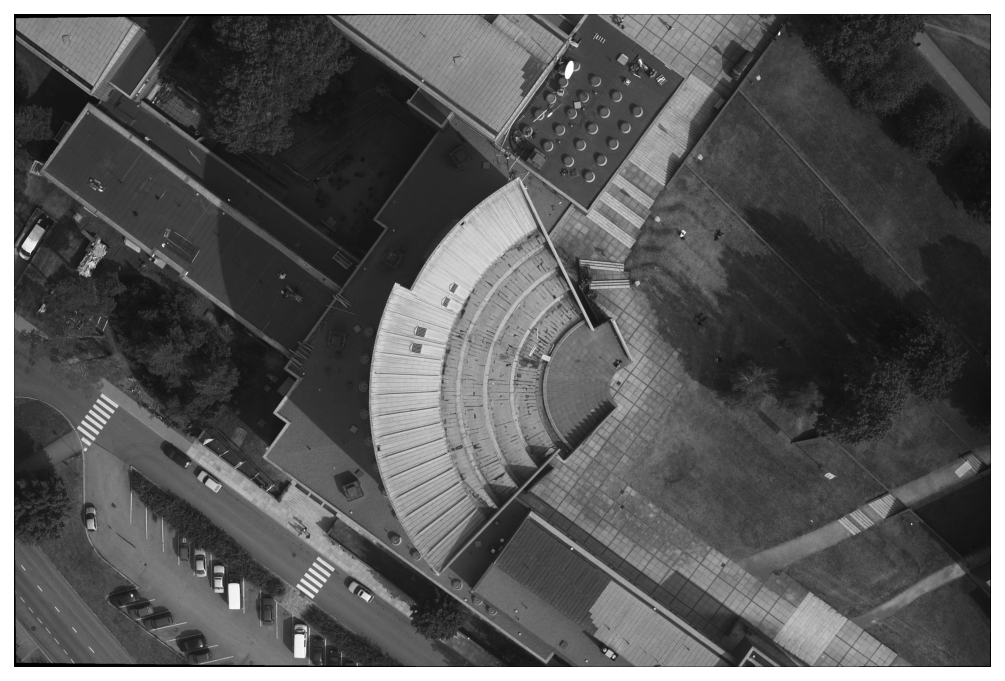

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.imshow(orthophoto, cmap='gray', vmin=0, vmax=255)
ax.set_axis_off()

plt.show()

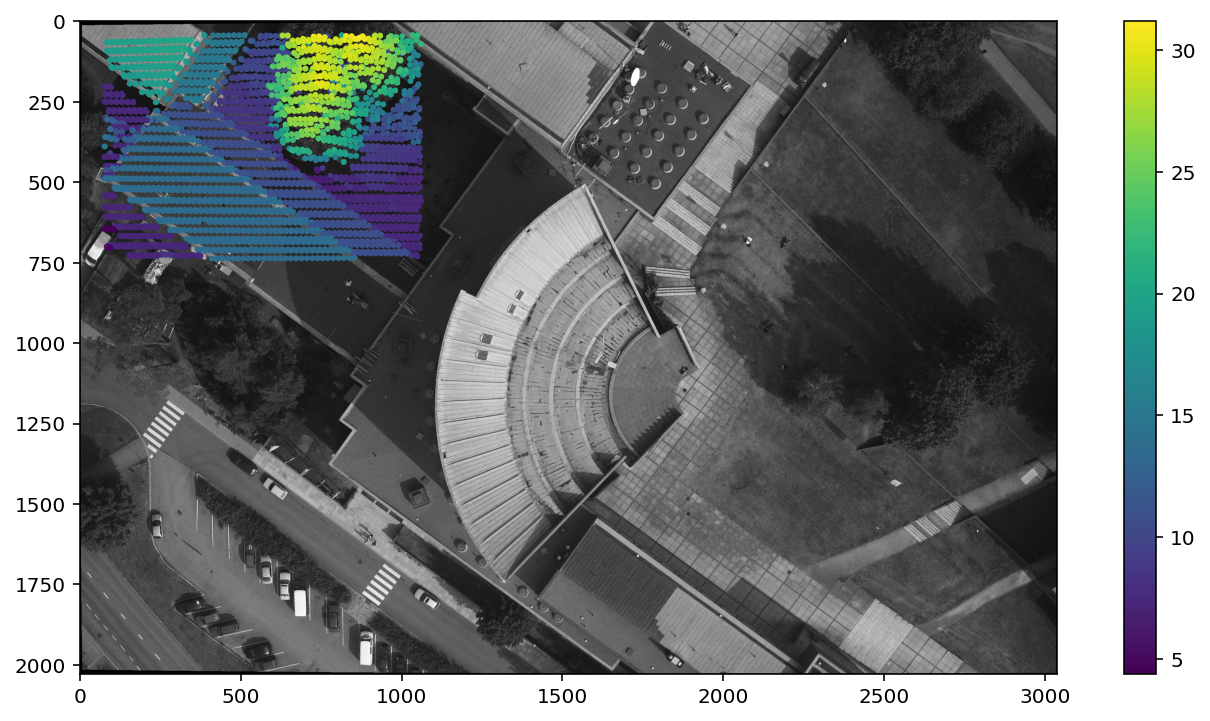

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.imshow(orthophoto, cmap='gray', vmin=0, vmax=255)

pos = ax.scatter(x_img, y_img, s=4, c=laser_z)

# ax.set_axis_off()

fig.colorbar(pos, ax=ax)

plt.show()

In [19]:
x_img.min(), x_img.max()

(76.22362888090515, 1060.428522887546)

In [20]:
y_img.min(), y_img.max()

(42.528562913274754, 736.9618744119136)

In [21]:
min_row, max_row = int(np.round(y_img.min())), int(np.round(y_img.max()))

In [22]:
min_col, max_col = int(np.round(x_img.min())), int(np.round(x_img.max()))

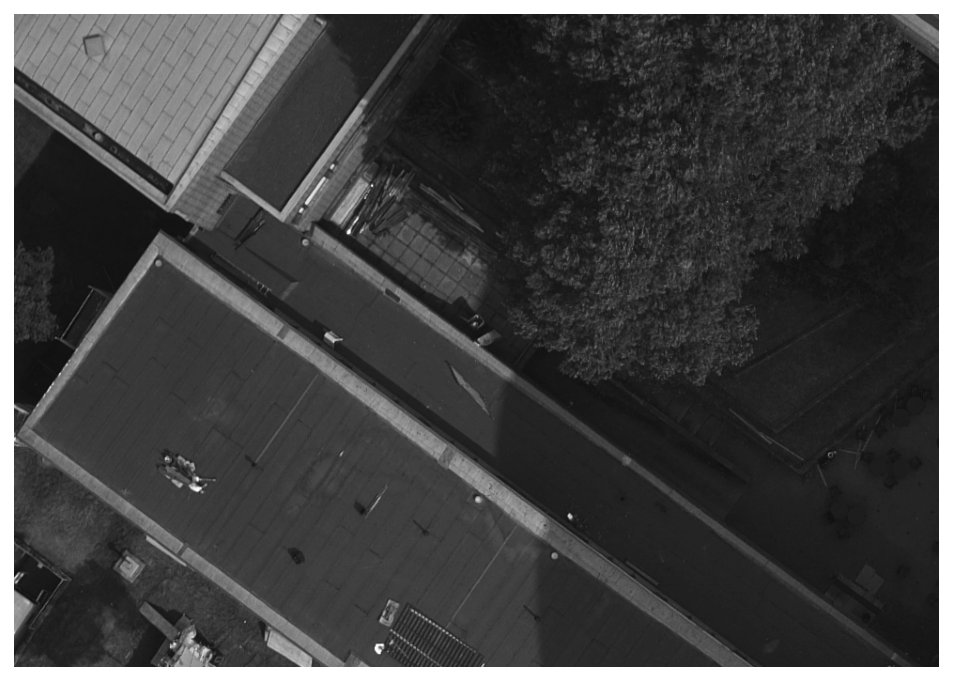

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.imshow(orthophoto[min_row:max_row+1, min_col:max_col+1], cmap='gray', vmin=0, vmax=255)

ax.set_axis_off()

In [25]:
def d(x, x_i):

    try:
        X, Y = x
        X_i, Y_i = x_i
        return np.sqrt((X - X_i) ** 2 + (Y - Y_i) ** 2)
    except:
        print('was it testing with 1D?')
        return np.sqrt((x - x_i) ** 2)


def w(d_i, p=2):
    return 1 / d_i**p


def u(neighbours_u, neighbours_d):

    n = len(neighbours_d)

    weights = []
    for i in range(n):
        d_i = neighbours_d[i]
        weight_i = w(d_i)
        weights.append(weight_i)

        # print(f'weight {i+1}: {weight_i}')

    sum_weights = np.sum(weights)

    total = 0
    for i in range(n):
        u_i = neighbours_u[i]
        w_i = weights[i]
        to_add = w_i * u_i
        total += to_add

        # print(f'w{i + 1}u{i+1}: {to_add}')

    result = total / sum_weights
    return result

In [26]:
xy_img = np.vstack((x_img, y_img)).T

In [27]:
tree = KDTree(xy_img)

pixels_rows, pixels_columns = max_row - min_row, max_col - min_col
DEM = np.zeros((pixels_rows, pixels_columns))

with tqdm(total=pixels_rows*pixels_columns) as pb:

    for i, Y in enumerate(range(min_row, max_row)):
    
        for j, X in enumerate(range(min_col, max_col)):

            dist, ind = tree.query(np.array([[X, Y], ]), k=5)
            # ind/dist shape: 1 x k
            neighbours_u = laser_z[ind[0]]
            neighbours_d = dist[0]

            interpolated_height = u(neighbours_d=neighbours_d,
                                    neighbours_u=neighbours_u)
            DEM[i, j] = interpolated_height
            pb.update()

  0%|          | 0/682896 [00:00<?, ?it/s]

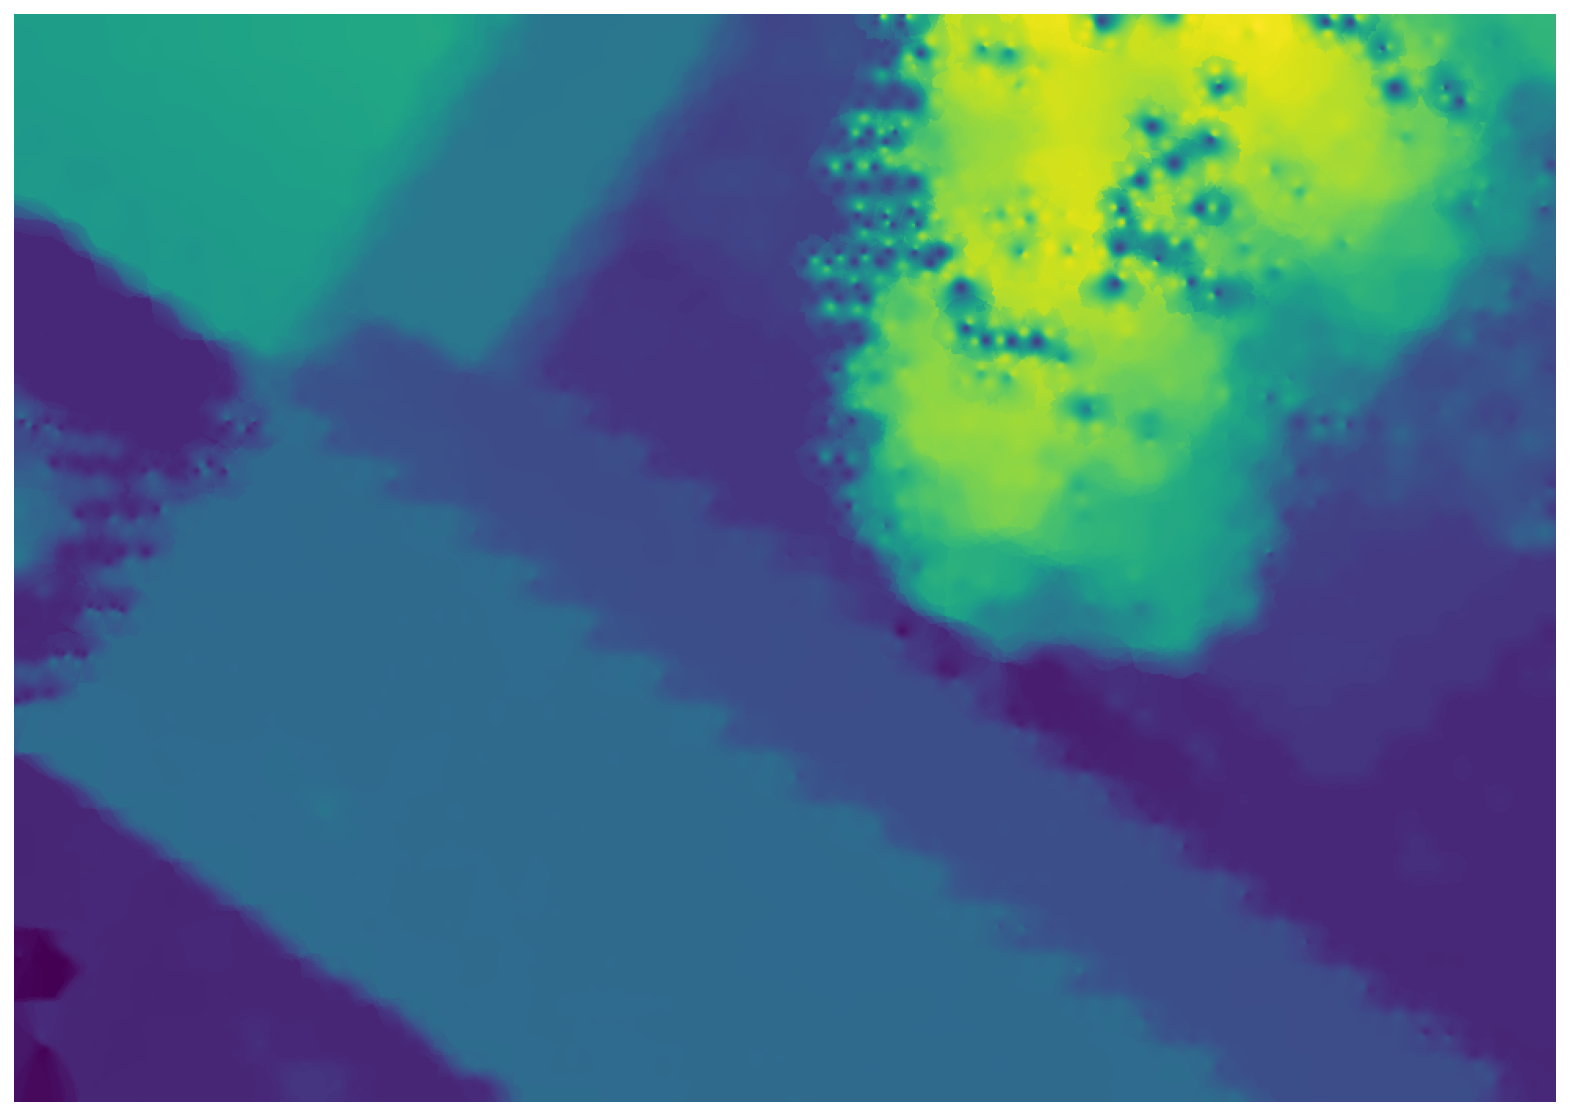

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(DEM)
ax.set_axis_off()

plt.savefig("interpolation_height.pdf");

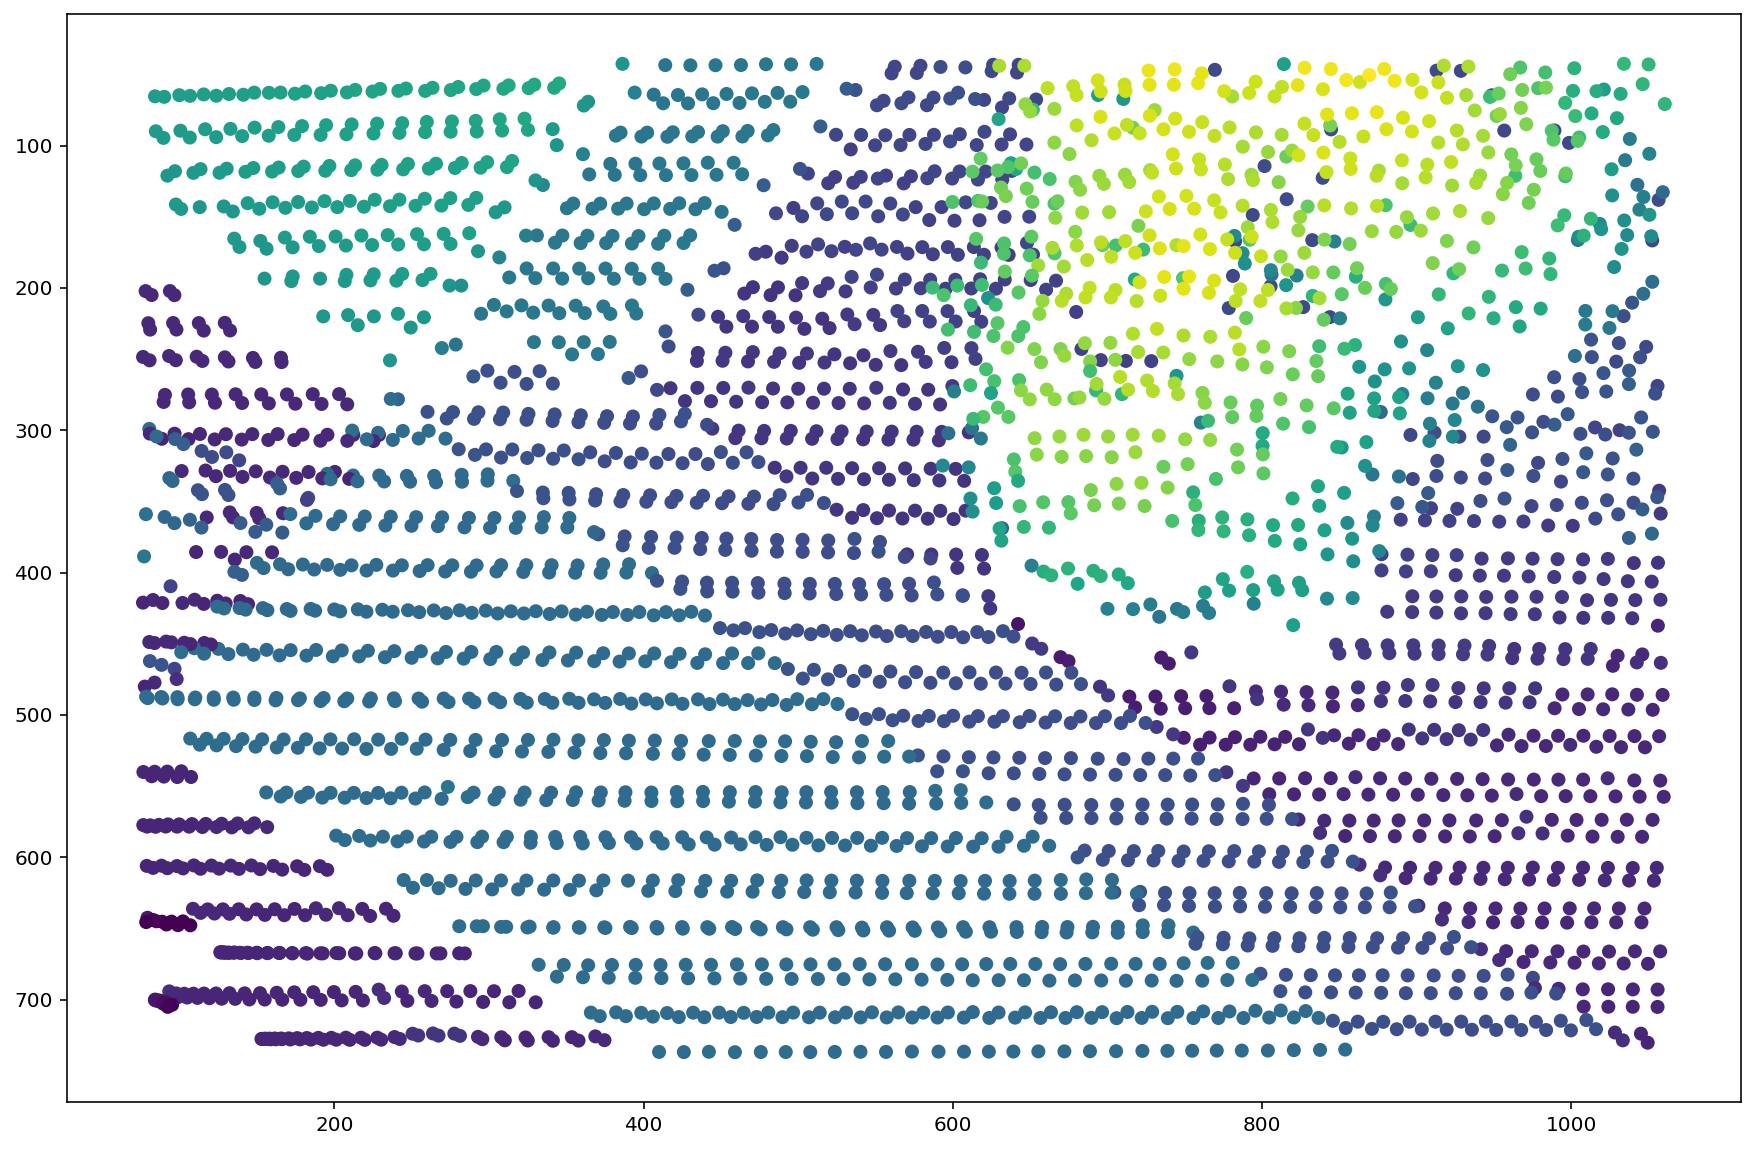

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x_img, y_img, c=laser_z)
ax.invert_yaxis()

plt.savefig("scatter_laser_data.pdf");

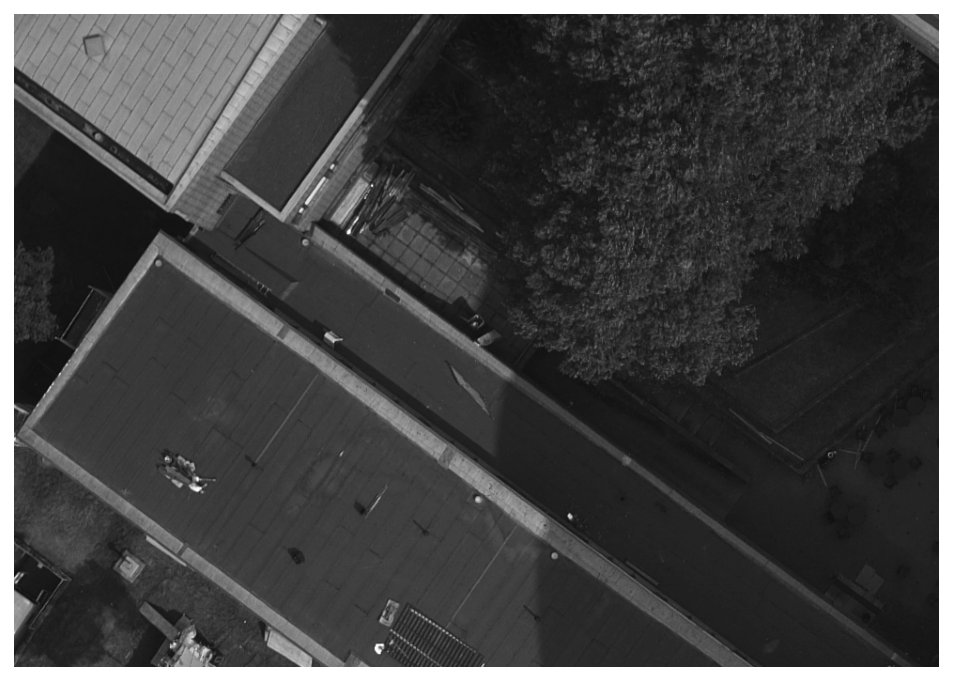

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.imshow(orthophoto[min_row:max_row+1, min_col:max_col+1], cmap='gray', vmin=0, vmax=255)

ax.set_axis_off()

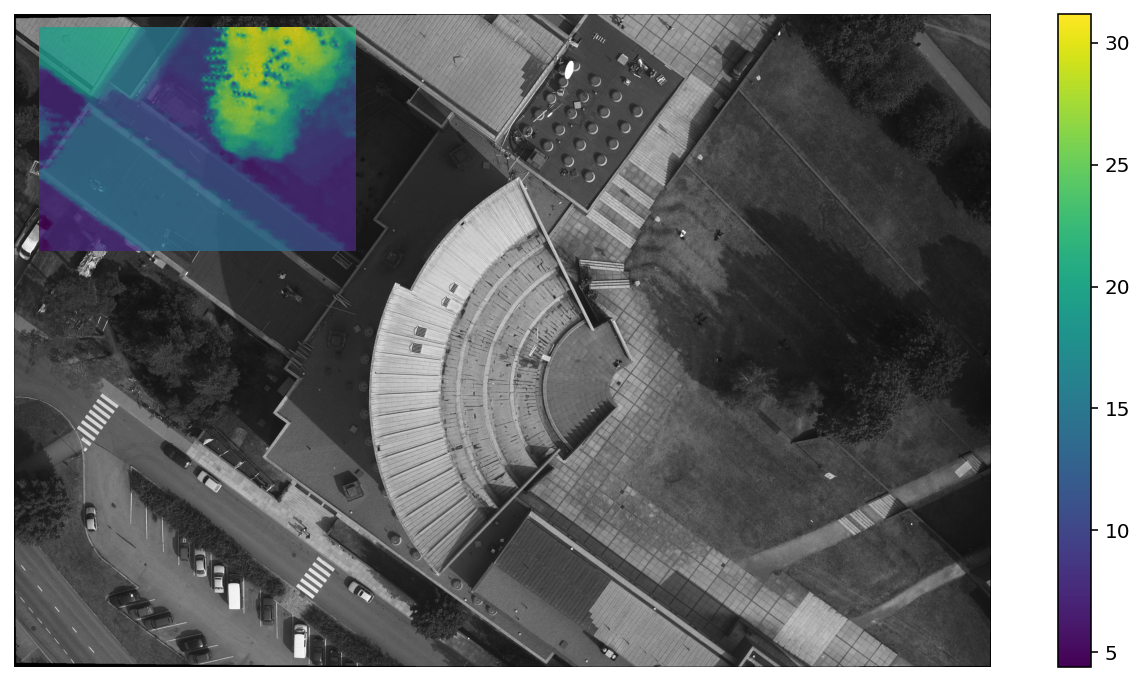

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

left, right, bottom, top = 0, orthophoto.shape[1], orthophoto.shape[0], 0
ax.imshow(orthophoto, cmap='gray', vmin=0, vmax=255, extent=(left, right, bottom, top))

left, right, bottom, top = min_col, max_col, max_row, min_row
ax.imshow(DEM, extent=(left, right, bottom, top), alpha=0.8)

ax.set_xlim(0, orthophoto.shape[1])
ax.set_ylim(orthophoto.shape[0], 0)

# pos = ax.scatter(x_img, y_img, s=4, c=laser_z)

ax.set_axis_off()

fig.colorbar(pos, ax=ax)


plt.savefig("interpolation_height_original_image.pdf");

plt.show()

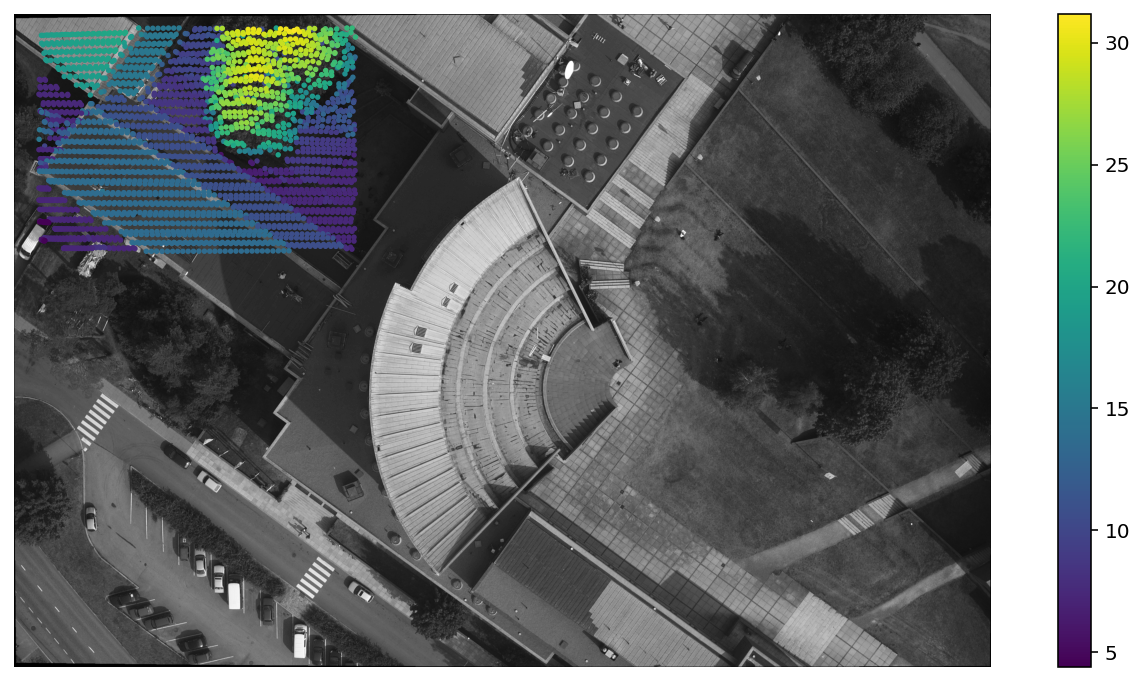

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

left, right, bottom, top = 0, orthophoto.shape[1], orthophoto.shape[0], 0
ax.imshow(orthophoto, cmap='gray', vmin=0, vmax=255, extent=(left, right, bottom, top))

#left, right, bottom, top = min_col, max_col, max_row, min_row
#ax.imshow(DEM, extent=(left, right, bottom, top), alpha=0.5)

ax.set_xlim(0, orthophoto.shape[1])
ax.set_ylim(orthophoto.shape[0], 0)

pos = ax.scatter(x_img, y_img, s=3, c=laser_z)

ax.set_axis_off()

fig.colorbar(pos, ax=ax)


plt.savefig("scatter_original_image.pdf");

plt.show()

In [38]:
laser_xy_img = xy_img

In [42]:
n_pixel = (max_row - min_row) * (max_col - min_col)
pixel_xy_img = np.zeros((n_pixel, 2))

i = 0

for Y in range(min_row, max_row):
    
    for X in range(min_col, max_col):
        pixel_xy_img[i, :] = X, Y
        
        i += 1
        

In [43]:
n_laser = len(laser_x) 

In [44]:
orthophoto.shape

(2028, 3037)

In [75]:
tree = KDTree(pixel_xy_img)

laser_gray = np.zeros(n_laser)

k = 5

with tqdm(total=n_laser) as pb:

    for i, (X, Y) in enumerate(laser_xy_img):

        dist, ind = tree.query(np.array([[X, Y], ]), k=k)
        # ind/dist shape: 1 x k

        coordinates_neighbours = pixel_xy_img[ind[0]]
        neighbours_u = np.zeros(k)
        for j, (x, y) in enumerate(coordinates_neighbours):
            neighbours_u[j] = orthophoto[int(x), int(y)]

        neighbours_d = dist[0]

        laser_gray[i] = u(neighbours_d=neighbours_d,
                          neighbours_u=neighbours_u)

        pb.update()

  0%|          | 0/2896 [00:00<?, ?it/s]

In [76]:
laser_gray

array([76.02225363, 75.50802482, 60.95461766, ..., 42.70773149,
       50.05509172, 39.55414328])

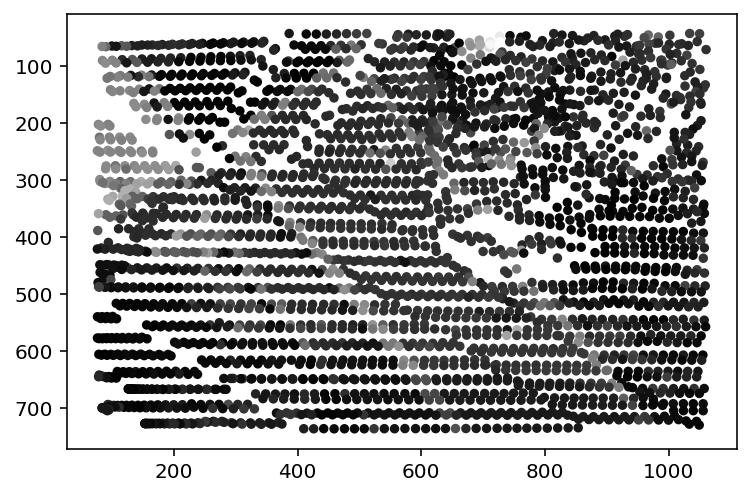

In [78]:
fig, ax = plt.subplots()
ax.scatter(*laser_xy_img.T, s=14, c=laser_gray, cmap='gray')
ax.invert_yaxis()


In [79]:
pixel_xy_img

array([[  76.,   43.],
       [  77.,   43.],
       [  78.,   43.],
       ...,
       [1057.,  736.],
       [1058.,  736.],
       [1059.,  736.]])